# Workflows
To demonstrate the workflows implemented in the `atomistics` package, the [LAMMPS](https://www.lammps.org/) molecular 
dynamics simulation code is used in the following demonstrations. Still the same `workflows` can also be used with other
simulation codes:

In [1]:
from atomistics.calculators import evaluate_with_lammps, get_potential_by_name

potential_dataframe = get_potential_by_name(
    potential_name='1999--Mishin-Y--Al--LAMMPS--ipr1'
)
result_dict = evaluate_with_lammps(
    task_dict={},
    potential_dataframe=potential_dataframe,
)

The interatomic potential for Aluminium from Mishin named `1999--Mishin-Y--Al--LAMMPS--ipr1` is used in the evaluation
with [LAMMPS](https://www.lammps.org/) `evaluate_with_lammps()`. 

## Elastic Matrix 
The elastic constants and elastic moduli can be calculated using the `ElasticMatrixWorkflow`: 

In [2]:
from ase.build import bulk
from atomistics.calculators import evaluate_with_lammps, get_potential_by_name
from atomistics.workflows import ElasticMatrixWorkflow

potential_dataframe = get_potential_by_name(
    potential_name='1999--Mishin-Y--Al--LAMMPS--ipr1'
)
workflow = ElasticMatrixWorkflow(
    structure=bulk("Al", cubic=True), 
    num_of_point=5, 
    eps_range=0.005, 
    sqrt_eta=True, 
    fit_order=2,
)
task_dict = workflow.generate_structures()
result_dict = evaluate_with_lammps(
    task_dict=task_dict,
    potential_dataframe=potential_dataframe,
)
fit_dict = workflow.analyse_structures(output_dict=result_dict)
print(fit_dict)

OrderedDict([('SGN', 225), ('v0', 66.43012500000002), ('LC', 'CI'), ('Lag_strain_list', ['01', '08', '23']), ('epss', array([-0.005 , -0.0025,  0.    ,  0.0025,  0.005 ])), ('e0', -13.439999952539933), ('strain_energy', [[(-0.005, -13.436318571477456), (-0.0025, -13.439078837682322), (0.0, -13.439999952539933), (0.0024999999999999996, -13.439085818358748), (0.005, -13.436366000141689)], [(-0.005, -13.438173590018806), (-0.0025, -13.43954407461901), (0.0, -13.439999952539933), (0.0024999999999999996, -13.439548790708864), (0.005, -13.438205313732144)], [(-0.005, -13.436741916886653), (-0.0025, -13.439195456175232), (0.0, -13.439999952539933), (0.0024999999999999996, -13.439213481749942), (0.005, -13.436885676373926)]]), ('C', array([[114.10393023,  60.51098897,  60.51098897,   0.        ,
          0.        ,   0.        ],
       [ 60.51098897, 114.10393023,  60.51098897,   0.        ,
          0.        ,   0.        ],
       [ 60.51098897,  60.51098897, 114.10393023,   0.        ,

The `ElasticMatrixWorkflow` takes an `ase.atoms.Atoms` object as `structure` input as well as the number of points 
`num_of_point` for each compression direction. Depending on the symmetry of the input `structure` the number of 
calculations required to calculate the elastic matrix changes. The compression and elongation range is defined by the
`eps_range` parameter. Furthermore, `sqrt_eta` and `fit_order` describe how the change in energy over compression and
elongation is fitted to calculate the resulting pressure. 

## Energy Volume Curve
The `EnergyVolumeCurveWorkflow` can be used to calculate the equilibrium properties: equilibrium volume, equilibrium 
energy, equilibrium bulk modulus and the pressure derivative of the equilibrium bulk modulus. 

In [3]:
from ase.build import bulk
from atomistics.calculators import evaluate_with_lammps, get_potential_by_name
from atomistics.workflows import EnergyVolumeCurveWorkflow

potential_dataframe = get_potential_by_name(
    potential_name='1999--Mishin-Y--Al--LAMMPS--ipr1'
)
workflow = EnergyVolumeCurveWorkflow(
    structure=bulk("Al", cubic=True), 
    num_points=11,
    fit_type="polynomial",
    fit_order=3,
    vol_range=0.05,
    axes=("x", "y", "z"),
    strains=None,
)
task_dict = workflow.generate_structures()
result_dict = evaluate_with_lammps(
    task_dict=task_dict,
    potential_dataframe=potential_dataframe,
)
fit_dict = workflow.analyse_structures(output_dict=result_dict)
print(fit_dict)

{'poly_fit': array([-4.17645808e-05,  1.19746500e-02, -1.03803906e+00,  1.49168639e+01]), 'fit_type': 'polynomial', 'fit_order': 3, 'volume_eq': 66.43019853103964, 'energy_eq': -13.43996804374383, 'bulkmodul_eq': 77.7250135953191, 'b_prime_eq': 1.279502459079921, 'least_square_error': 3.225313797039607e-10, 'volume': [63.10861874999998, 63.77291999999998, 64.43722124999998, 65.1015225, 65.76582375000004, 66.43012500000002, 67.09442624999994, 67.75872750000002, 68.42302874999999, 69.08732999999997, 69.75163125000002], 'energy': [-13.398169481534445, -13.413389552957456, -13.425112589013958, -13.433411420804067, -13.438357630783006, -13.439999952539933, -13.438383476946305, -13.433607982916406, -13.425774537190858, -13.414961805921427, -13.401233093668836]}


The input parameters for the `EnergyVolumeCurveWorkflow` in addition to the `ase.atoms.Atoms` object defined 
as `structure` are: 

* `num_points` the number of strains to calculate energies and volumes.  
* `fit_type` the type of the fit which should be used to calculate the equilibrium properties. This can either be a 
  `polynomial` fit or a specific equation of state like the Birch equation (`birch`), the Birch-Murnaghan equation 
  (`birchmurnaghan`) the Murnaghan equation (`murnaghan`), the Pourier Tarnatola eqaution (`pouriertarantola`) or the
  Vinet equation (`vinet`).  
* `fit_order` for the `polynomial` fit type the order of the polynomial can be set, for the other fit types this 
  parameter is ignored. 
* `vol_range` specifies the amount of compression and elongation to be applied relative to the absolute volume. 
* `axes` specifies the axes which are compressed, typically a uniform compression is applied. 
* `strains` specifies the strains directly rather than deriving them from the range of volume compression `vol_range`. 

Beyond calculating the equilibrium properties the `EnergyVolumeCurveWorkflow` can also be used to calculate the thermal
properties using the [Moruzzi, V. L. et al.](https://link.aps.org/doi/10.1103/PhysRevB.37.790)  model: 

In [4]:
tp_dict = workflow.get_thermal_properties(
    t_min=1,
    t_max=1500,
    t_step=50,
    temperatures=None,
    constant_volume=False,
)
print(tp_dict)

{'temperatures': array([   1,   51,  101,  151,  201,  251,  301,  351,  401,  451,  501,
        551,  601,  651,  701,  751,  801,  851,  901,  951, 1001, 1051,
       1101, 1151, 1201, 1251, 1301, 1351, 1401, 1451, 1501]), 'free_energy': array([ 0.18879418,  0.18840183,  0.18352524,  0.16909367,  0.1440755 ,
        0.10931095,  0.06593656,  0.01498215, -0.04269081, -0.1063728 ,
       -0.1754776 , -0.24951635, -0.328077  , -0.41080851, -0.49740877,
       -0.58761537, -0.68119851, -0.77795536, -0.87770572, -0.98028844,
       -1.08555864, -1.19338539, -1.3036498 , -1.41624343, -1.53106703,
       -1.6480294 , -1.76704645, -1.88804043, -2.01093923, -2.13567578,
       -2.26218757]), 'entropy': array([  0.75685476,   5.08219062,  18.62461552,  38.05446426,
        57.6693229 ,  75.37710506,  90.99476554, 104.78762778,
       117.06473011, 128.09164494, 138.08127289, 147.20167195,
       155.58579193, 163.33970927, 170.54896552, 177.28330938,
       183.60022562, 189.54757244, 195.165

Or alternatively directly calculate the thermal expansion:

In [5]:
temperatures, volumes = workflow.get_thermal_expansion(
    output_dict=result_dict, 
    t_min=1, 
    t_max=1500, 
    t_step=50, 
    temperatures=None,
)

The [Moruzzi, V. L. et al.](https://link.aps.org/doi/10.1103/PhysRevB.37.790)  model is a quantum mechanical approximation, so the equilibrium volume at 0K is not
the same as the equilibrium volume calculated by fitting the equation of state. 

## Molecular Dynamics 
Just like the structure optimization also the molecular dynamics calculation can either be implemented inside the
simulation code or in the `atomistics` package. The latter has the advantage that it is the same implementation for all
different simulation codes, while the prior has the advantage that it is usually faster and computationally more efficient.

### Implemented in Simulation Code 
The [LAMMPS](https://lammps.org/) simulation code implements a wide range of different simulation workflows, this 
includes molecular dynamics. In the `atomistics` package these can be directly accessed via the python interface. 

#### Langevin Thermostat
The Langevin thermostat is currently the only thermostat which is available as both a stand-alone python interface and
an integrated interface inside the [LAMMPS](https://lammps.org/) simulation code. The latter is introduced here:

In [6]:
from ase.build import bulk
from atomistics.calculators import (
    calc_molecular_dynamics_langevin_with_lammps, 
    get_potential_by_name,
)

potential_dataframe = get_potential_by_name(
    potential_name='1999--Mishin-Y--Al--LAMMPS--ipr1'
)
result_dict = calc_molecular_dynamics_langevin_with_lammps(
    structure=bulk("Al", cubic=True).repeat([10, 10, 10]),
    potential_dataframe=potential_dataframe,
    Tstart=100,
    Tstop=100,
    Tdamp=0.1,
    run=100,
    thermo=10,
    timestep=0.001,
    seed=4928459,
    dist="gaussian",
    output=("positions", "cell", "forces", "temperature", "energy_pot", "energy_tot", "pressure", "velocities"),
)

In addition to the typical LAMMPS input parameters like the atomistic structure `structure` as `ase.atoms.Atoms` object
and the `pandas.DataFrame` for the interatomic potential `potential_dataframe` are: 

* `Tstart` start temperature 
* `Tstop` end temperature
* `Tdamp` temperature damping parameter 
* `run` number of molecular dynamics steps to be executed during one temperature step
* `thermo` refresh rate for the thermo dynamic properties, this should typically be the same as the number of molecular
  dynamics steps. 
* `timestep` time step - typically 1fs defined as `0.001`.
* `seed` random seed for the molecular dynamics 
* `dist` initial velocity distribution 
* `lmp` Lammps library instance as `pylammpsmpi.LammpsASELibrary` object 
* `output` the output quantities which are extracted from the molecular dynamics simulation

#### Nose Hoover Thermostat
Canonical ensemble (nvt) - volume and temperature constraints molecular dynamics:

In [7]:
from ase.build import bulk
from atomistics.calculators import (
    calc_molecular_dynamics_nvt_with_lammps, 
    get_potential_by_name,
)

potential_dataframe = get_potential_by_name(
    potential_name='1999--Mishin-Y--Al--LAMMPS--ipr1'
)
result_dict = calc_molecular_dynamics_nvt_with_lammps(
    structure=bulk("Al", cubic=True).repeat([10, 10, 10]),
    potential_dataframe=potential_dataframe,
    Tstart=100,
    Tstop=100,
    Tdamp=0.1,
    run=100,
    thermo=10,
    timestep=0.001,
    seed=4928459,
    dist="gaussian",
    output=("positions", "cell", "forces", "temperature", "energy_pot", "energy_tot", "pressure"),
)

In addition to the typical LAMMPS input parameters like the atomistic structure `structure` as `ase.atoms.Atoms` object
and the `pandas.DataFrame` for the interatomic potential `potential_dataframe` are: 

* `Tstart` start temperature 
* `Tstop` end temperature
* `Tdamp` temperature damping parameter 
* `run` number of molecular dynamics steps to be executed during one temperature step
* `thermo` refresh rate for the thermo dynamic properties, this should typically be the same as the number of molecular
  dynamics steps. 
* `timestep` time step - typically 1fs defined as `0.001`.
* `seed` random seed for the molecular dynamics 
* `dist` initial velocity distribution 
* `lmp` Lammps library instance as `pylammpsmpi.LammpsASELibrary` object 
* `output` the output quantities which are extracted from the molecular dynamics simulation

Isothermal-isobaric ensemble (npt) - pressure and temperature constraints molecular dynamics:

In [8]:
from ase.build import bulk
from atomistics.calculators import (
    calc_molecular_dynamics_npt_with_lammps, 
    get_potential_by_name,
)

potential_dataframe = get_potential_by_name(
    potential_name='1999--Mishin-Y--Al--LAMMPS--ipr1'
)
result_dict = calc_molecular_dynamics_npt_with_lammps(
    structure=bulk("Al", cubic=True).repeat([10, 10, 10]),
    potential_dataframe=potential_dataframe,
    Tstart=100,
    Tstop=100,
    Tdamp=0.1,
    run=100,
    thermo=100,
    timestep=0.001,
    Pstart=0.0,
    Pstop=0.0,
    Pdamp=1.0,
    seed=4928459,
    dist="gaussian",
    output=("positions", "cell", "forces", "temperature", "energy_pot", "energy_tot", "pressure"),
)

The input parameters for the isothermal-isobaric ensemble (npt) are the same as for the canonical ensemble (nvt) plus:

* `Pstart` start pressure 
* `Pstop` end pressure 
* `Pdamp` pressure damping parameter 

Isenthalpic ensemble (nph) - pressure and helmholtz-energy constraints molecular dynamics:

In [9]:
from ase.build import bulk
from atomistics.calculators import (
    calc_molecular_dynamics_nph_with_lammps, 
    get_potential_by_name,
)

potential_dataframe = get_potential_by_name(
    potential_name='1999--Mishin-Y--Al--LAMMPS--ipr1'
)
result_dict = calc_molecular_dynamics_nph_with_lammps(
    structure=bulk("Al", cubic=True).repeat([10, 10, 10]),
    potential_dataframe=potential_dataframe,
    run=100,
    thermo=100,
    timestep=0.001,
    Tstart=100,
    Pstart=0.0,
    Pstop=0.0,
    Pdamp=1.0,
    seed=4928459,
    dist="gaussian",
    output=("positions", "cell", "forces", "temperature", "energy_pot", "energy_tot", "pressure"),
)

#### Thermal Expansion
One example of a molecular dynamics calculation with the LAMMPS simulation code is the calculation of the thermal 
expansion: 

In [10]:
from ase.build import bulk
from atomistics.calculators import (
    calc_molecular_dynamics_thermal_expansion_with_lammps, 
    evaluate_with_lammps, 
    get_potential_by_name,
)

potential_dataframe = get_potential_by_name(
    potential_name='1999--Mishin-Y--Al--LAMMPS--ipr1'
)
temperatures_md, volumes_md = calc_molecular_dynamics_thermal_expansion_with_lammps(
    structure=bulk("Al", cubic=True).repeat([10, 10, 10]),
    potential_dataframe=potential_dataframe,
    Tstart=100,
    Tstop=1000,
    Tstep=100,
    Tdamp=0.1,
    run=100,
    thermo=100,
    timestep=0.001,
    Pstart=0.0,
    Pstop=0.0,
    Pdamp=1.0,
    seed=4928459,
    dist="gaussian",
    lmp=None,
)

In addition to the typical LAMMPS input parameters like the atomistic structure `structure` as `ase.atoms.Atoms` object
and the `pandas.DataFrame` for the interatomic potential `potential_dataframe` are: 

* `Tstart` start temperature 
* `Tstop` end temperature 
* `Tstep` temperature step 
* `Tdamp` temperature damping parameter 
* `run` number of molecular dynamics steps to be executed during one temperature step
* `thermo` refresh rate for the thermo dynamic properties, this should typically be the same as the number of molecular
  dynamics steps. 
* `timestep` time step - typically 1fs defined as `0.001`.
* `Pstart` start pressure 
* `Pstop` end pressure 
* `Pdamp` pressure damping parameter 
* `seed` random seed for the molecular dynamics 
* `dist` initial velocity distribution 
* `lmp` Lammps library instance as `pylammpsmpi.LammpsASELibrary` object 

These input parameters are based on the LAMMPS fix `nvt/npt`, you can read more about the specific implementation on the
[LAMMPS website](https://docs.lammps.org/fix_nh.html). 


#### Phonons from Molecular Dynamics
The softening of the phonon modes is calculated for Silicon using the [Tersoff interatomic potential](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.38.9902) 
which is available via the [NIST potentials repository](https://www.ctcms.nist.gov/potentials/entry/1988--Tersoff-J--Si-c/). 
Silicon is chosen based on its diamond crystal lattice which requires less calculation than the face centered cubic (fcc)
crystal of Aluminium. The simulation workflow consists of three distinct steps:

* Starting with the optimization of the equilibrium structure. 
* Followed by the calculation of the 0K phonon spectrum. 
* Finally, the finite temperature phonon spectrum is calculated using molecular dynamics. 

The finite temperature phonon spectrum is calculated using the [DynaPhoPy](https://abelcarreras.github.io/DynaPhoPy/)
package, which is integrated inside the `atomistics` package. As a prerequisite the dependencies, imported and the bulk 
silicon diamond structure is created and the Tersoff interatomic potential is loaded: 

In [11]:
from ase.build import bulk
from atomistics.calculators import (
    calc_molecular_dynamics_phonons_with_lammps,
    evaluate_with_lammps, 
)
from atomistics.workflows import optimize_positions_and_volume, PhonopyWorkflow
from dynaphopy import Quasiparticle
import pandas
from phonopy.units import VaspToTHz
import spglib

structure_bulk = bulk("Si", cubic=True)
potential_dataframe = get_potential_by_name(
    potential_name='1988--Tersoff-J--Si-c--LAMMPS--ipr1'
)

The first step is optimizing the Silicon diamond structure to match the lattice specifications implemented in the Tersoff 
interatomic potential:

In [12]:
task_dict = optimize_positions_and_volume(structure=structure_bulk)
result_dict = evaluate_with_lammps(
    task_dict=task_dict,
    potential_dataframe=potential_dataframe,
)
structure_ase = result_dict["structure_with_optimized_positions_and_volume"]

As a second step the 0K phonons are calculated using the `PhonopyWorkflow` which is explained in more detail below in 
the section on [Phonons](https://atomistics.readthedocs.io/en/latest/workflows.html#phonons). 

In [13]:
cell = (structure_ase.cell.array, structure_ase.get_scaled_positions(), structure_ase.numbers)
primitive_matrix = spglib.standardize_cell(cell=cell, to_primitive=True)[0] / structure_ase.get_volume() ** (1/3)
workflow = PhonopyWorkflow(
    structure=structure_ase,
    interaction_range=10,
    factor=VaspToTHz,
    displacement=0.01,
    dos_mesh=20,
    primitive_matrix=primitive_matrix,
    number_of_snapshots=None,
)
task_dict = workflow.generate_structures()
result_dict = evaluate_with_lammps(
    task_dict=task_dict,
    potential_dataframe=potential_dataframe,
)
workflow.analyse_structures(output_dict=result_dict)

({'qpoints': array([[0.025, 0.025, 0.025],
         [0.075, 0.025, 0.025],
         [0.125, 0.025, 0.025],
         ...,
         [0.525, 0.525, 0.425],
         [0.475, 0.475, 0.475],
         [0.525, 0.475, 0.475]]),
  'weights': array([ 2,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
          6,  6,  6,  6, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12, 12, 12, 12,  6, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12, 12, 12, 12, 12,  6, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12, 12, 12, 12, 12,  6, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12, 12, 12, 12,  6, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12, 12,  6, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
          6, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  6, 12, 12, 12,
         12, 12, 12, 12, 12, 12, 12, 12,  6, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12,  6, 12, 12, 12, 12, 12, 12, 12, 12,  6, 12, 12, 12, 12, 12,


The calcualtion of the finite temperature phonons starts by computing the molecular dynamics trajectory using the 
`calc_molecular_dynamics_phonons_with_lammps()` function. This function is internally linked to [DynaPhoPy](https://abelcarreras.github.io/DynaPhoPy/)
to return an `dynaphopy.dynamics.Dynamics` object: 

In [14]:
trajectory = calc_molecular_dynamics_phonons_with_lammps(
    structure_ase=structure_ase,
    potential_dataframe=potential_dataframe,
    force_constants=workflow.phonopy.get_force_constants(), 
    phonopy_unitcell=workflow.phonopy.get_unitcell(),
    phonopy_primitive_matrix=workflow.phonopy.get_primitive_matrix(),
    phonopy_supercell_matrix=workflow.phonopy.get_supercell_matrix(),
    total_time=2,       # ps
    time_step=0.001,    # ps
    relaxation_time=5,  # ps
    silent=True,
    supercell=[2, 2, 2],
    memmap=False,
    velocity_only=True,
    temperature=600,
)

When a total of 2 picoseconds is selected to compute the finite temperature phonons with a timestep of 1 femto second
then this results in a total of 2000 molecular dynamics steps. While more molecular dynamics steps result in more precise
predictions they also require more computational resources. 

The postprocessing is executed using the [DynaPhoPy](https://abelcarreras.github.io/DynaPhoPy/) package: 

In [15]:
calculation = Quasiparticle(trajectory)
calculation.select_power_spectra_algorithm(2)  # select FFT algorithm
calculation.get_renormalized_phonon_dispersion_bands()
renormalized_force_constants = calculation.get_renormalized_force_constants().get_array()
renormalized_force_constants

Using 2000 steps
Using Fast Fourier transform (Numpy) function
set frequency range: 0.0 - 21.200000000000003

Q-point: 1 / 32     [ 0.00000  0.00000  0.00000 ]
Harmonic frequencies (THz):
[2.18910938e-06 2.19854601e-06 2.20383682e-06 1.60678991e+01
 1.60678991e+01 1.60678991e+01]
Calculating phonon projection power spectra
Projecting into phonon mode
Projecting into wave vector
MD cell size relation: [2 2 2]
Power spectrum resolution requested unavailable, using maximum:  0.500000 THz
If you need higher resolution increase the number of data
FFT: [##############################] 100.00% Done...

Peak # 1
----------------------------------------------
Width                             0.503412 THz
Position                          0.030228 THz
Area (<K>)    (Lorentzian)        0.000000 eV
Area (<K>)    (Total)             0.000000 eV
<|dQ/dt|^2>                       0.000000 eV
Occupation number                -0.500000
Fit temperature                        nan K
Base line            

array([[[[ 1.47901738e+01, -7.27856474e-04,  8.95058148e-04],
         [-7.27856474e-04,  1.47901738e+01,  8.95058148e-04],
         [ 8.95058148e-04,  8.95058148e-04,  1.47888052e+01]],

        [[-8.43844610e-03,  7.27856474e-04, -8.95058148e-04],
         [ 7.27856474e-04,  7.28656134e-03,  8.95058148e-04],
         [-8.95058148e-04,  8.95058148e-04,  8.65518224e-03]],

        [[ 7.28656134e-03,  7.27856474e-04,  8.95058148e-04],
         [ 7.27856474e-04, -8.43844610e-03, -8.95058148e-04],
         [ 8.95058148e-04, -8.95058148e-04,  8.65518224e-03]],

        ...,

        [[-4.34304104e-03,  1.31864165e-04, -2.95050844e-03],
         [ 1.31864165e-04,  3.82031823e-03,  9.26457597e-03],
         [-2.95050844e-03,  9.26457597e-03,  2.59330404e-03]],

        [[ 3.82031823e-03,  1.31864165e-04,  9.26457597e-03],
         [ 1.31864165e-04, -4.34304104e-03, -2.95050844e-03],
         [ 9.26457597e-03, -2.95050844e-03,  2.59330404e-03]],

        [[ 4.40243519e-03, -7.86267323e-04,  7

It calculates the re-normalized force constants which can then be used to calculate the finite temperature properties. 

In addition the [DynaPhoPy](https://abelcarreras.github.io/DynaPhoPy/) package can be used to directly compare the 
finite temperature phonon spectrum with the 0K phonon spectrum calulated with the finite displacement method: 

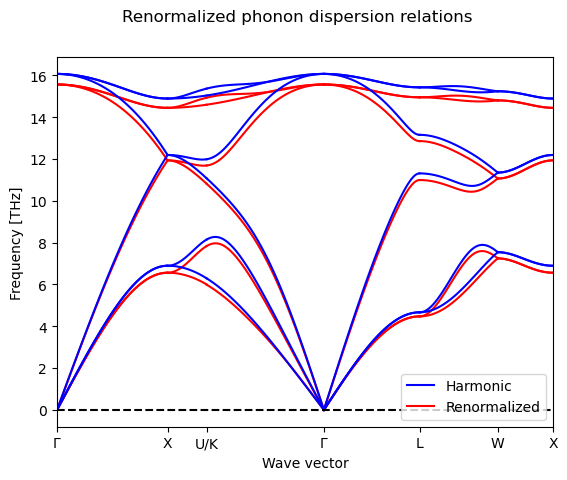

In [16]:
calculation.plot_renormalized_phonon_dispersion_bands()

### Langevin Thermostat 
In addition to the molecular dynamics implemented in the LAMMPS simulation code, the `atomistics` package also provides
the `LangevinWorkflow` which implements molecular dynamics independent of the specific simulation code. 


In [17]:
from ase.build import bulk
from atomistics.calculators import evaluate_with_lammps_library, get_potential_by_name
from atomistics.workflows import LangevinWorkflow
from pylammpsmpi import LammpsASELibrary

steps = 300
potential_dataframe = get_potential_by_name(
    potential_name='1999--Mishin-Y--Al--LAMMPS--ipr1'
)
workflow = LangevinWorkflow(
    structure=bulk("Al", cubic=True).repeat([2, 2, 2]), 
    temperature=1000.0,
    overheat_fraction=2.0,
    damping_timescale=100.0,
    time_step=1,
)
lmp = LammpsASELibrary(
    working_directory=None,
    cores=1,
    comm=None,
    logger=None,
    log_file=None,
    library=None,
    diable_log_file=True,
)
eng_pot_lst, eng_kin_lst = [], []
for i in range(steps):
    task_dict = workflow.generate_structures()
    result_dict = evaluate_with_lammps_library(
        task_dict=task_dict,
        potential_dataframe=potential_dataframe,
        lmp=lmp,
    )
    eng_pot, eng_kin = workflow.analyse_structures(output_dict=result_dict)
    eng_pot_lst.append(eng_pot)
    eng_kin_lst.append(eng_kin)
lmp.close()

The advantage of this implementation is that the user can directly interact with the simulation between the individual
molecular dynamics simulation steps. This provides a lot of flexibility to prototype new simulation methods. The input
parameters of the `LangevinWorkflow` are:

* `structure` the `ase.atoms.Atoms` object which is used as initial structure for the molecular dynamics calculation 
* `temperature` the temperature of the molecular dynamics calculation given in Kelvin
* `overheat_fraction` the over heating fraction of the Langevin thermostat
* `damping_timescale` the damping timescale of the Langevin thermostat 
* `time_step` the time steps of the Langevin thermostat


## Harmonic Approximation 
The harmonic approximation is implemented in two variations, once with constant volume and once including the volume 
expansion at finite temperature also known as quasi-harmonic approximation. Both of these are based on the [phonopy](https://phonopy.github.io/phonopy/)
package. 

### Phonons 
To calculate the phonons at a fixed volume the `PhonopyWorkflow` is used:

In [18]:
from ase.build import bulk
from atomistics.calculators import evaluate_with_lammps, get_potential_by_name
from atomistics.workflows import PhonopyWorkflow
from phonopy.units import VaspToTHz

potential_dataframe = get_potential_by_name(
    potential_name='1999--Mishin-Y--Al--LAMMPS--ipr1'
)
workflow = PhonopyWorkflow(
    structure=bulk("Al", cubic=True), 
    interaction_range=10,
    factor=VaspToTHz,
    displacement=0.01,
    dos_mesh=20,
    primitive_matrix=None,
    number_of_snapshots=None,
)
task_dict = workflow.generate_structures()
result_dict = evaluate_with_lammps(
    task_dict=task_dict,
    potential_dataframe=potential_dataframe,
)
phonopy_dict = workflow.analyse_structures(output_dict=result_dict)

The `PhonopyWorkflow` takes the following inputs: 

* `structure` the `ase.atoms.Atoms` object to calculate the phonon spectrum
* `interaction_range` the cutoff radius to consider for identifying the interaction between the atoms
* `factor` conversion factor, typically just `phonopy.units.VaspToTHz` 
* `displacement` displacement to calculate the forces 
* `dos_mesh` mesh for the density of states 
* `primitive_matrix` primitive matrix
* `number_of_snapshots` number of snapshots to calculate

In addition to the phonon properties, the `PhonopyWorkflow` also enables the calculation of thermal properties: 

In [19]:
tp_dict = workflow.get_thermal_properties(
    t_min=1, 
    t_max=1500, 
    t_step=50, 
    temperatures=None,
    cutoff_frequency=None,
    pretend_real=False,
    band_indices=None,
    is_projection=False,
)
print(tp_dict)

{'temperatures': array([1.000e+00, 5.100e+01, 1.010e+02, 1.510e+02, 2.010e+02, 2.510e+02,
       3.010e+02, 3.510e+02, 4.010e+02, 4.510e+02, 5.010e+02, 5.510e+02,
       6.010e+02, 6.510e+02, 7.010e+02, 7.510e+02, 8.010e+02, 8.510e+02,
       9.010e+02, 9.510e+02, 1.001e+03, 1.051e+03, 1.101e+03, 1.151e+03,
       1.201e+03, 1.251e+03, 1.301e+03, 1.351e+03, 1.401e+03, 1.451e+03,
       1.501e+03]), 'free_energy': array([ 0.14914132,  0.14837894,  0.13954171,  0.11738723,  0.08264779,
        0.03712237, -0.01759836, -0.08025513, -0.14986079, -0.22563203,
       -0.30693668, -0.39325592, -0.48415731, -0.57927552, -0.67829812,
       -0.78095507, -0.88701079, -0.99625805, -1.10851315, -1.22361223,
       -1.3414082 , -1.46176834, -1.58457228, -1.70971039, -1.8370824 ,
       -1.96659625, -2.09816715, -2.23171671, -2.3671723 , -2.5044664 ,
       -2.64353611]), 'entropy': array([1.10363972e-08, 5.98829810e+00, 2.96478195e+01, 5.54593816e+01,
       7.80099308e+01, 9.71787932e+01, 1.136085

The calculation of the thermal properties takes additional inputs: 

* `t_min` minimum temperature
* `t_max` maximum temperature
* `t_step` temperature step 
* `temperatures` alternative to `t_min`, `t_max` and `t_step` the array of temperatures can be defined directly
* `cutoff_frequency` cutoff frequency to exclude the contributions of frequencies below a certain cut off
* `pretend_real` use the absolute values of the phonon frequencies
* `band_indices` select bands based on their indices 
* `is_projection` multiplies the squared eigenvectors - not recommended

Furthermore, also the dynamical matrix can be directly calculated with the `PhonopyWorkflow`:


In [20]:
mat = workflow.get_dynamical_matrix()
mat

array(None, dtype=object)

Or alternatively the hesse matrix:

In [21]:
mat = workflow.get_hesse_matrix()
mat

array([[ 4.50127147e-02, -1.92714960e-33,  8.52306995e-33, ...,
        -6.63514216e-05,  8.82979633e-06,  5.93920137e-05],
       [-5.07378488e-34,  4.50127147e-02,  5.07378488e-34, ...,
         8.82979633e-06, -6.63514216e-05,  5.93920137e-05],
       [ 5.07378488e-34, -5.07378488e-34,  4.50127147e-02, ...,
         5.93659141e-05,  5.93659141e-05,  1.73512126e-05],
       ...,
       [-6.63514216e-05,  8.82979633e-06,  5.93920137e-05, ...,
         4.50127147e-02, -1.92714960e-33,  8.52306995e-33],
       [ 8.82979633e-06, -6.63514216e-05,  5.93920137e-05, ...,
        -5.07378488e-34,  4.50127147e-02,  5.07378488e-34],
       [ 5.93659141e-05,  5.93659141e-05,  1.73512126e-05, ...,
         5.07378488e-34, -5.07378488e-34,  4.50127147e-02]])

Finally, also the function to calculate the band structure is directly available on the `PhonopyWorkflow`: 

In [22]:
band_structure = workflow.get_band_structure(
    npoints=101, 
    with_eigenvectors=False, 
    with_group_velocities=False
)

This band structure can also be visualised using the built-in plotting function: 

<Axes: title={'center': 'Bandstructure'}, xlabel='Bandpath', ylabel='Frequency [THz]'>

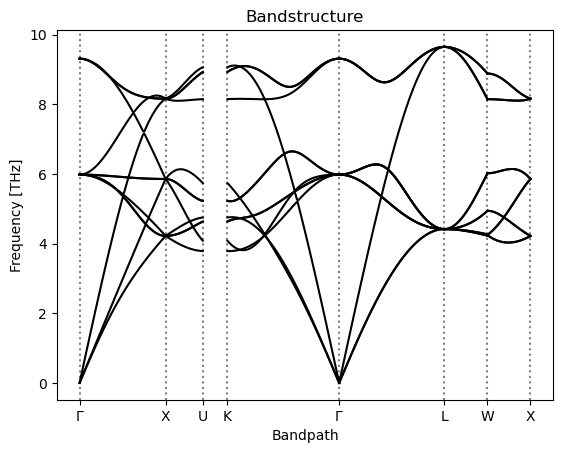

In [23]:
workflow.plot_band_structure()

Just like the desnsity of states which can be plotted using:

<Axes: title={'center': 'Phonon DOS vs Energy'}, xlabel='Frequency [THz]', ylabel='DOS'>

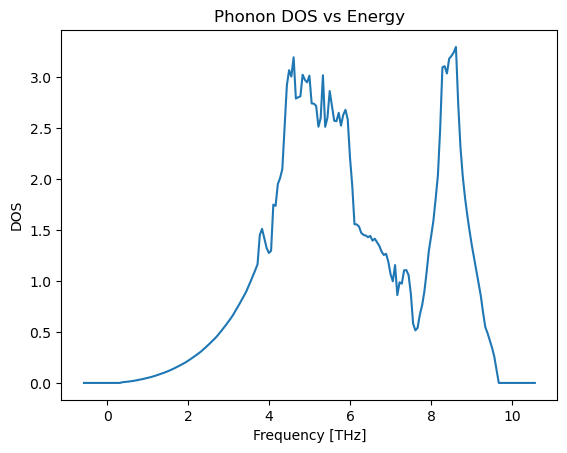

In [24]:
workflow.plot_dos()

### Quasi-harmonic Approximation 
To include the volume expansion with finite temperature the `atomistics` package implements the `QuasiHarmonicWorkflow`:

In [25]:
from ase.build import bulk
from atomistics.calculators import evaluate_with_lammps, get_potential_by_name
from atomistics.workflows import QuasiHarmonicWorkflow

potential_dataframe = get_potential_by_name(
    potential_name='1999--Mishin-Y--Al--LAMMPS--ipr1'
)
workflow = QuasiHarmonicWorkflow(
    structure=bulk("Al", cubic=True), 
    num_points=11,
    vol_range=0.05,
    interaction_range=10,
    factor=VaspToTHz,
    displacement=0.01,
    dos_mesh=20,
    primitive_matrix=None,
    number_of_snapshots=None,
)
task_dict = workflow.generate_structures()
result_dict = evaluate_with_lammps(
    task_dict=task_dict,
    potential_dataframe=potential_dataframe,
)
fit_dict = workflow.analyse_structures(output_dict=result_dict)

The `QuasiHarmonicWorkflow` is a combination of the `EnergyVolumeCurveWorkflow` and the `PhonopyWorkflow`. Consequently, 
the inputs are a superset of the inputs of these two workflows. 

Based on the `QuasiHarmonicWorkflow` the thermal properties can be calculated:

In [26]:
tp_dict = workflow.get_thermal_properties(
    t_min=1, 
    t_max=1500, 
    t_step=50, 
    temperatures=None,
    cutoff_frequency=None,
    pretend_real=False,
    band_indices=None,
    is_projection=False,
    quantum_mechanical=True,
)
print(tp_dict)

{'temperatures': array([1.000e+00, 5.100e+01, 1.010e+02, 1.510e+02, 2.010e+02, 2.510e+02,
       3.010e+02, 3.510e+02, 4.010e+02, 4.510e+02, 5.010e+02, 5.510e+02,
       6.010e+02, 6.510e+02, 7.010e+02, 7.510e+02, 8.010e+02, 8.510e+02,
       9.010e+02, 9.510e+02, 1.001e+03, 1.051e+03, 1.101e+03, 1.151e+03,
       1.201e+03, 1.251e+03, 1.301e+03, 1.351e+03, 1.401e+03, 1.451e+03,
       1.501e+03]), 'free_energy': array([ 0.1490366 ,  0.14826761,  0.13934538,  0.11699115,  0.08193384,
        0.03597288, -0.01929866, -0.08261783, -0.15299316, -0.22963661,
       -0.31191108, -0.39929276, -0.49134426, -0.58769537, -0.68802891,
       -0.7920703 , -0.89957955, -1.01034525, -1.12417973, -1.24091537,
       -1.36040152, -1.48250213, -1.6070937 , -1.73406366, -1.86330899,
       -1.99473507, -2.12825469, -2.26378725, -2.40125802, -2.54059753,
       -2.68174106]), 'entropy': array([1.36944221e-05, 5.98139595e+00, 2.96871756e+01, 5.55859383e+01,
       7.82416454e+01, 9.75225732e+01, 1.140663

This requires the same inputs as the calculation of the thermal properties `get_thermal_properties()` with the 
`PhonopyWorkflow`. The additional parameter `quantum_mechanical` specifies whether the classical harmonic oscillator or 
the quantum mechanical harmonic oscillator is used to calculate the free energy. 

And finally also the thermal expansion can be calculated:

In [27]:
temperatures, volumes = workflow.get_thermal_expansion(
    output_dict=result_dict, 
    t_min=1, 
    t_max=1500, 
    t_step=50, 
    temperatures=None,
    cutoff_frequency=None,
    pretend_real=False,
    band_indices=None,
    is_projection=False,
    quantum_mechanical=True,
)

## Structure Optimization 
In analogy to the molecular dynamics calculation also the structure optimization could in principle be defined inside 
the simulation code or on the python level. Still currently the `atomistics` package only supports the structure 
optimization defined inside the simulation codes. 

### Volume and Positions 
To optimize both the volume of the supercell as well as the positions inside the supercell the `atomistics` package
implements the `optimize_positions_and_volume()` workflow:

In [28]:
from ase.build import bulk
from atomistics.calculators import evaluate_with_lammps, get_potential_by_name
from atomistics.workflows import optimize_positions_and_volume

structure = bulk("Al", a=4.0, cubic=True)
potential_dataframe = get_potential_by_name(
    potential_name='1999--Mishin-Y--Al--LAMMPS--ipr1'
)
result_dict = evaluate_with_lammps(
    task_dict=optimize_positions_and_volume(structure=structure),
    potential_dataframe=potential_dataframe,
)
structure_opt = result_dict["structure_with_optimized_positions_and_volume"]
structure_opt

Atoms(symbols='Al4', pbc=True, cell=[[4.05000466219724, 2.4799126230458533e-16, 2.4799126230458533e-16], [0.0, 4.05000466219724, 2.4799126230458533e-16], [0.0, 0.0, 4.05000466219724]])

The result is the optimized atomistic structure as part of the result dictionary. 

### Positions 
The optimization of the positions inside the supercell without the optimization of the supercell volume is possible with
the `optimize_positions()` workflow:

In [29]:
from ase.build import bulk
from atomistics.calculators import evaluate_with_lammps, get_potential_by_name
from atomistics.workflows import optimize_positions

structure = bulk("Al", a=4.0, cubic=True)
potential_dataframe = get_potential_by_name(
    potential_name='1999--Mishin-Y--Al--LAMMPS--ipr1'
)
result_dict = evaluate_with_lammps(
    task_dict=optimize_positions(structure=structure),
    potential_dataframe=potential_dataframe,
)
structure_opt = result_dict["structure_with_optimized_positions"]
structure_opt

Atoms(symbols='Al4', pbc=True, cell=[4.0, 4.0, 4.0])

The result is the optimized atomistic structure as part of the result dictionary. 